# Analisis of Runs 1 and 2
## Calculate individual current as a function of time for different tilt angles.

This notebook takes the raw data from runs 1 and 2 and produces the dataset 

    "../Data/Processed/23_07_20_Script5_currents.hdf"
    
This notebook takes about 15 minutes in a single core

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
directories = dict(odd = "../Data/Run2-OddRun",
                  even = "../Data/Run1-PlainRun")

In [3]:
directories

{'odd': '../Data/Run2-OddRun', 'even': '../Data/Run1-PlainRun'}

This structure below creates a superindex from the indices of both datasets. 

In [4]:
index = {key:pd.read_csv(
    os.path.join(directories[key],"index.dat"), 
    names = ["file", "height", "tilt","max_frame"], sep=" ") for key in directories}

index = pd.concat(index)

index["parity"] = index.index.get_level_values(0)
index["fid_origin"] = index.index.get_level_values(1)

index.index = pd.Index(range(len(index)))

In [5]:
index.head()

,file,height,tilt,max_frame,parity,fid_origin
0,Tilt_24_deg_h3899_2023_07_23_19_18_56,3.9,24,599864,odd,0
1,Tilt_9_deg_h3899_2023_07_23_19_18_56,3.9,9,599864,odd,1
2,Tilt_17_deg_h3899_2023_07_23_19_18_56,3.9,17,599864,odd,2
3,Tilt_26_deg_h3899_2023_07_23_19_18_56,3.9,26,599864,odd,3
4,Tilt_0_deg_h3899_2023_07_23_19_18_56,3.9,0,599864,odd,4


## Development: Calculate the current from a sample trayectory

In [6]:
entry = index.query("tilt == 10").iloc[0]

location = os.path.join(directories[entry.parity], entry.file+".lammpstrj")

trj_read = mgc.trj_lazyread(location, 
                     output = ["x","y","z"])
trj = trj_read[:]
bounds = trj_read.get_bounds()

timestep = 1e-4
trj["time"] = trj.index.get_level_values("frame")*timestep

trj = trj.filter(["time", "x","y","z"])

In [7]:
trj.head()

time          x          y         z
frame id                                      
0     1    0.0 -28.963200 -30.360701  0.561224
      2    0.0 -31.590700 -30.360701 -0.561224
      3    0.0 -22.589100 -30.360701  0.561224
      4    0.0 -25.216600 -30.360701 -0.561224
      5    0.0 -16.215099 -30.360701  0.561224

In [8]:
vels = sp.calculate_velocities(trj, bounds.loc[[0]])

trj = trj.join(vels.filter(["x", "y", "z"]), how="right", rsuffix = "_v")

trj.head()

time          x          y         z  x_v  y_v  z_v
frame id                                                     
0     1    0.0 -28.963200 -30.360701  0.561224  NaN  NaN  NaN
      2    0.0 -31.590700 -30.360701 -0.561224  NaN  NaN  NaN
      3    0.0 -22.589100 -30.360701  0.561224  NaN  NaN  NaN
      4    0.0 -25.216600 -30.360701 -0.561224  NaN  NaN  NaN
      5    0.0 -16.215099 -30.360701  0.561224  NaN  NaN  NaN

In [9]:
trj["I_x"] = trj.eval("y_v * z / abs(z)")
trj["I_y"] = -trj.eval("x_v * z / abs(z)")

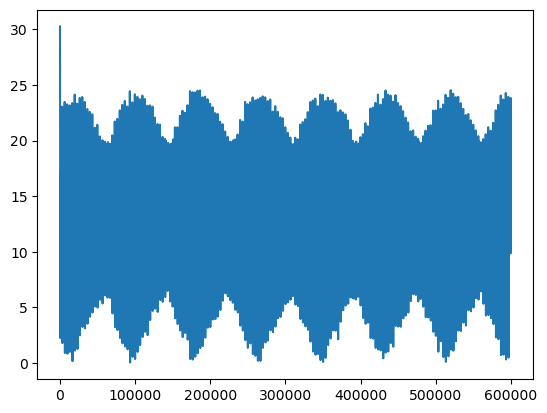

In [10]:
plt.plot(trj.groupby("frame").mean().eval("sqrt(I_x**2+I_y**2)"))

In [11]:
trj.head()

time          x          y         z  x_v  y_v  z_v  I_x  I_y
frame id                                                               
0     1    0.0 -28.963200 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN
      2    0.0 -31.590700 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN
      3    0.0 -22.589100 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN
      4    0.0 -25.216600 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN
      5    0.0 -16.215099 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN

### Let's wrap everything in a function to run it as a batch
We can use this to save to all the currents to a file

In [12]:
def calculate_currents(entry):

    # Read entry from .lammpstrj
    location = os.path.join(directories[entry.parity], entry.file+".lammpstrj")
    trj_read = mgc.trj_lazyread(location, 
                         output = ["x","y","z"])
    trj = trj_read[:]
    bounds = trj_read.get_bounds()

    ## add time column.
    timestep = 1e-4
    trj["time"] = trj.index.get_level_values("frame")*timestep
    trj = trj.filter(["time", "x","y","z"])
    
    ## Calculate velocities
    
    vels = sp.calculate_velocities(trj, bounds.loc[[0]])
    trj = trj.join(vels.filter(["x", "y", "z"]), how="right", rsuffix = "_v")
    
    ## Calculate Currents
    trj["I_x"] = trj.eval("y_v * z / abs(z)")
    trj["I_y"] = -trj.eval("x_v * z / abs(z)")
    trj["I"] = trj.eval("sqrt(I_x**2+I_y**2)")
    
    return trj, bounds

In [13]:
trj, bnd = calculate_currents(entry)
trj.head()

time          x          y         z  x_v  y_v  z_v  I_x  I_y   I
frame id                                                                   
0     1    0.0 -28.963200 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN NaN
      2    0.0 -31.590700 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN NaN
      3    0.0 -22.589100 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN NaN
      4    0.0 -25.216600 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN NaN
      5    0.0 -16.215099 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN NaN

## Run Analisis: Save everything to a single hdf file

    ../Data/Processed/23_07_20_Script5_currents.hdf

In [14]:
trj

time          x          y         z        x_v        y_v  \
frame  id                                                                   
0      1     0.0000 -28.963200 -30.360701  0.561224        NaN        NaN   
       2     0.0000 -31.590700 -30.360701 -0.561224        NaN        NaN   
       3     0.0000 -22.589100 -30.360701  0.561224        NaN        NaN   
       4     0.0000 -25.216600 -30.360701 -0.561224        NaN        NaN   
       5     0.0000 -16.215099 -30.360701  0.561224        NaN        NaN   
...             ...        ...        ...       ...        ...        ...   
599864 235  59.9864  16.061399  -5.731850 -0.556726  11.970040  -0.612579   
       236  59.9864  23.065901  -3.403060  0.558156 -12.185559   4.031144   
       237  59.9864  22.532400  -5.868900 -0.568287  16.532944  -4.970042   
       238  59.9864  29.495001  -3.312300  0.559006 -15.820258   1.684434   
       239  59.9864  28.597700  -5.667310 -0.559747   9.365310 -10.180845   

                 z_v        I_x        I_y          I  
frame  id                                              
0      1         NaN        NaN        NaN        NaN  
       2         NaN        NaN        NaN        NaN  
       3         NaN        NaN        NaN        NaN  
       4         NaN        NaN        NaN        NaN  
       5         NaN        NaN        NaN        NaN  
...              ...        ...        ...        ...  
599864 235  0.693894   0.612579  11.970040  11.985705  
       236 -0.207246   4.031144  12.185559  12.835029  
       237 -0.742817   4.970042  16.532944  17.263822  
       238 -0.087547   1.684434  15.820258  15.909679  
       239  0.120180  10.180845   9.365310  13.833244  

[858727 rows x 10 columns]

In [15]:
%%time

!mkdir ../Data/Processed/
file = "../Data/Processed/23_07_25_Script5_currents.hdf"
index.to_hdf(file, mode = "w", key = "index")

subindex = index

for i,entry in tqdm(subindex.iterrows(), total = len(index)):
    trj, bnd = calculate_currents(entry)
    trj.to_hdf(file, mode = "a", key = entry.file)
    bnd.to_hdf(file, mode = "a", key = "bounds/"+entry.file)

mkdir: cannot create directory ‘../Data/Processed/’: File exists


  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 6min 38s, sys: 6.97 s, total: 6min 45s
Wall time: 6min 43s


In [16]:
file = "../Data/Processed/23_07_25_Script5_currents.hdf"

index = pd.read_hdf("../Data/Processed/23_07_25_Script5_currents.hdf", key = "index")

aggregate = []

for i,entry in tqdm(subindex.iterrows(), total = len(index)):
    trj = pd.read_hdf(file, key = entry.file)
    timeseries = trj.groupby("time").I_x.mean().to_frame("I_x")
    timeseries["I_y"] = trj.groupby("time").I_y.mean()
    timeseries["var_x"] = trj.groupby("time").I_x.var()
    timeseries["var_y"] = trj.groupby("time").I_y.var()
    timeseries["N"] = trj.groupby("time").I.count()
    
    aggregate.append(timeseries)
    
aggregate = pd.concat(aggregate, 
      keys = list(subindex.filter(["tilt","parity"]).itertuples(index=False)),
      names = ["tilt","parity"])

  0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
aggregate.to_hdf("../Data/Processed/23_07_25_Script5_current_vs_time.hdf",
                 mode="w", key = "current_vs_time")